In [1]:
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
import numpy as np

In [3]:
from lenstronomy.LensModel.lens_model import LensModel
import lensinggw.constants.constants as const

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
from wolensing.plot.plot import plot_contour
import wolensing.amplification_factor.amplification_factor as af

In [5]:
G = const.G  # gravitational constant [m^3 kg^-1 s^-2]
c = const.c  # speed of light [m/s]
M_sun = const.M_sun  # Solar mass [Kg]

coordinates in scaled units [x (radians) /thetaE_tot]

In [6]:
y0, y1 = 0.5, 0 # source position
l0, l1 = 0., 0 # lens position

zS = 1.0 # source redshift
zL = 0.5 # lens redshift

In [7]:
mL1 = 100

# convert to radians
from lensinggw.utils.utils import param_processing
thetaE = param_processing(zL, zS, mL1)

In [8]:
beta0, beta1 = y0 * thetaE, y1 * thetaE
eta10, eta11 = 0 * l0 * thetaE, 0 * l1 * thetaE

In [9]:
lens_model_list = ['POINT_MASS']
kwargs_pm_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE}
kwargs_lens_list = [kwargs_pm_1]

In [10]:
lens_model_complete = LensModel(lens_model_list=lens_model_list)
T = lens_model_complete.fermat_potential
T0 = thetaE ** (-2) * T(eta10, eta11, kwargs_lens_list, beta0, beta1)#[0]
Tscale = 4 * (1 + zL) * mL1 * M_sun * G / c ** 3
print('T0 = {}'.format(T0))
print('Tscale = {}'.format(Tscale))

T0 = 57.68962732485115
Tscale = 0.0029552946153261453


In [11]:
kwargs_macro = {'source_pos_x': beta0,
                'source_pos_y': beta1,
                'theta_E': thetaE,
                'mu': 1
               }

In [12]:
# Define the characteristic WindowSize
mL_ref = 10
thetaE_ref = param_processing(zL, zS, mL_ref)

kwargs_integrator = {'PixelNum': int(20000),          # Number of pixels on each side of the window
                     'PixelBlockMax': 2000,           # Dividing PixelNum into PixelBlock
                     'WindowSize': 210*thetaE_ref, 
                     'WindowCenterX': eta10, 
                     'WindowCenterY': eta11,
                     'T0': T0,                        # Time delay of the reference point (WindowCenter)
                     'TimeStep': 1e-5/Tscale,         # integration step in time domain
                     'TimeMax': T0 + 1/Tscale,        # Upper bound of time integration
                     'TimeMin': T0 - .5/Tscale,       # Lower bound of time integration
                     'TimeLength': 4/Tscale,          
                     'TExtend': 10/Tscale,            # Extend the time domain curve to desired time. In this example, it is extended to T0+10 seconds 
                     'Tscale': Tscale}                

start


Integrating...: 100%|██████████| 121/121 [00:33<00:00,  3.67it/s]


total time 13.99999


<Figure size 640x480 with 0 Axes>

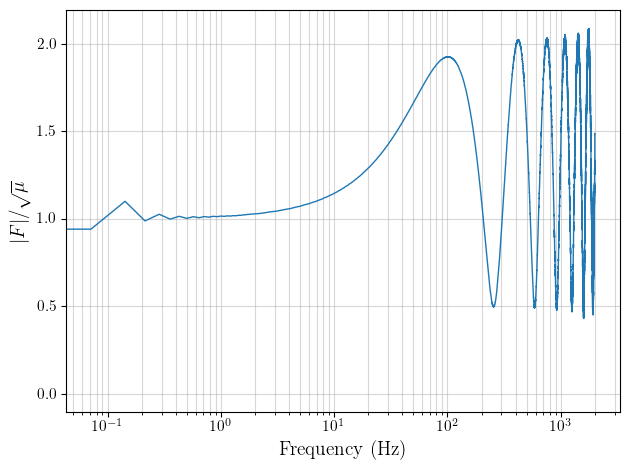

<AxesSubplot:xlabel='Frequency (Hz)', ylabel='$|F|/\\sqrt{\\mu}$'>

In [13]:
amplification = af.amplification_factor(lens_model_list=lens_model_list, kwargs_lens=kwargs_lens_list, kwargs_macro=kwargs_macro, **kwargs_integrator)
ts, F_tilde = amplification.integrator(gpu=False)
ws, Fws = amplification.fourier()
amplification.plot_freq()